Задание **Pro**

Сделайте оценку того, как блоки слов в словаре влияют на точность классификации (на любой базе, например, распознавание писателей). Для этого выполните следующее:

1.Сформируйте словарь.

2.Используйте первые 50000 слов из словаря, который формируется токенайзером (50000 самых часто-используемых слов). Обучите нейросеть на этой базе.

3.Разбейте все слова на блоки по 100 слов последовательно.

4.Проверьте точность модели с помощью model.evaluate() на немного измененной проверочной выборке. Используя цикл, поочередно отключайте блоки по одному. Сделайте так, чтобы эти слова не использовались при предсказании, например, их индексы всегда приравнивались к 0.

5.Оцените, как меняется точность классификации на проверочной выборке.

6.Сделайте выводы, какие блоки слов влияют в плюс, а какие в минус.

7. Соберите итоговую подборку слов, в которую войдут только те блоки по 100 слов, которые улучшили точность (исключение которых давало падение точности).
Обучите сеть только на этих блоках слов.

8.Оцените изменение точности в сравнении с обучением на полном словаре (первые 50000 слов).

**Так как экспериментов будет 4 для удобства проверки сделал ячейки кода так чтобы можно было их свернуть. Так же можно свернуть Обучение, График и Средний процент.**


**В конце будет сравнительная таблица для удобного просмотра результатов.**

# Общая подготовка

## Подключение библиотек

In [1]:
from google.colab import files 
import numpy as np 
import pandas as pd 
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.utils import plot_model
import os
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Подготовка данных 

In [3]:
# Создадим функцию для чтения файла с возратом нового файла без переноса на следующую строку
def readtext(fileName):
  return open(fileName, 'r').read().replace("\n", " ") 

In [4]:
# Объявим классы. Запишем в список
className = ["О. Генри", "Стругацкие", "Булгаков", "Клиффорд Саймак", "Макс Фрай", "Рэй Брэдберри"]

# Подсчитаем кол-во нужных нам классов
nClasses = len(className)

# Создадим 2 пустых списка (обучающий и проверочный), для последующего заполнения
trainText = []
testText = []

In [5]:
# Пройдемся двумя циклами для заполнения списков. Так чтобы каждый i элемент в обучающей выборке соответствовал j элементу в тестовой.

for i in className:
  for j in os.listdir('/content/drive/MyDrive/База тексты писателей/'):                     
    if i in j:                                       
      if 'Обучающая' in j:                           
        trainText.append(readtext('/content/drive/MyDrive/База тексты писателей/' +j))      
        print (j, 'добавлен в обучающую выборку')    
      if 'Тестовая' in j:                            
        testText.append(readtext('/content/drive/MyDrive/База тексты писателей/' +j))       
        print (j, 'добавлен в тестовую выборку')     

(О. Генри) Обучающая.txt добавлен в обучающую выборку
(О. Генри) Тестовая.txt добавлен в тестовую выборку
(Стругацкие) Обучающая.txt добавлен в обучающую выборку
(Стругацкие) Тестовая.txt добавлен в тестовую выборку
(Булгаков) Тестовая.txt добавлен в тестовую выборку
(Булгаков) Обучающая.txt добавлен в обучающую выборку
(Клиффорд Саймак) Обучающая.txt добавлен в обучающую выборку
(Клиффорд Саймак) Тестовая.txt добавлен в тестовую выборку
(Макс Фрай) Тестовая.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая.txt добавлен в обучающую выборку
(Рэй Брэдберри) Обучающая.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая.txt добавлен в тестовую выборку


## Обработка данных

In [6]:
# Преобразуем тектовые данные в числовые

# Зададим масимальное число индексов для обучения
maxWordsCount = 50000

# Токинизируем тескт на основе обучающей выборки
tokenizer = Tokenizer (num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', char_level=False, oov_token='unknow')

tokenizer.fit_on_texts(trainText)

In [7]:
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [8]:
print(items[100:150]) # взглянем на содержимое словаря

[('больше', 101), ('них', 102), ('через', 103), ('ведь', 104), ('человек', 105), ('знаю', 106), ('этом', 107), ('конечно', 108), ('какой', 109), ('почему', 110), ('дело', 111), ('пока', 112), ('глаза', 113), ('андрей', 114), ('потому', 115), ('чего', 116), ('им', 117), ('несколько', 118), ('при', 119), ('совершенно', 120), ('вдруг', 121), ('совсем', 122), ('мой', 123), ('всего', 124), ('всех', 125), ('никогда', 126), ('после', 127), ('такой', 128), ('сэр', 129), ('ним', 130), ('тогда', 131), ('лет', 132), ('над', 133), ('эти', 134), ('снова', 135), ('тем', 136), ('куда', 137), ('который', 138), ('вообще', 139), ('хорошо', 140), ('всегда', 141), ('всё', 142), ('люди', 143), ('этой', 144), ('перед', 145), ('мог', 146), ('ладно', 147), ('могу', 148), ('которые', 149), ('таки', 150)]


In [9]:
# Преобразововаем текст в последовательность индексов согласно словарю 
trainWordIndexes = tokenizer.texts_to_sequences(trainText)   # Создаем обучающий набор
testWordIndexes = tokenizer.texts_to_sequences(testText)     # И тестовый набор

## Функции для создания выборок: обучающей и проверочной

In [10]:
# Функция для разделения на короткие векторы
def getSetFromIndexes (wordIndexes, xLen, step):      
  xSample = []                                       
  wordsLen = len(wordIndexes)                       
  index = 0                                           
  while (index + xLen <= wordsLen):                     
    xSample.append(wordIndexes[index:index + xLen])   
    index += step                                    
  return xSample

In [11]:
# Функция для формирования обучающей и проверочной выборок
def createSetsMultiClasses(wordIndexes, xLen, step):

  # Создаем выборки из индексов для каждого из 6 классов
  nClasses = len(wordIndexes)
  classesXSamples = []
  for i in wordIndexes:
    classesXSamples.append(getSetFromIndexes(i,xLen,step))

  # Один общий список
  xSamples = []
  ySamples = []

  for t in range(nClasses):                               # В нашем случаи цикл от 0 до 6 (кол-во классов)
    xT = classesXSamples[t]                                # На каждой итерации цикла берем очередной нарезанный текст одного из класса

    for i in range (len(xT)):                             # Циклом проходимся по каждому его окну
      xSamples.append(xT[i])                              # Добавляем в общий список обучающей выборке
      ySamples.append(utils.to_categorical(t, nClasses))  # И соответствующий вектор класса

    # Первод в массив numpy
  xSamples = np.array(xSamples)                           
  ySamples = np.array(ySamples)    


  return (xSamples, ySamples)

## Подготовка данных

In [12]:
# Зададим базовые параметры
# Так как в пункте 3 указано разбить на блоки по 100 слов.

xLen = 100   # Ширина окна.  
step = 100    # Шаг разбиения

In [13]:
# Формирование обучающей и тестовой выборок
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step) 

In [14]:
# Посмотрим на размер всех данных
print('xTrain: ', xTrain.shape)
print('yTrain: ', yTrain.shape)
print('xTest: ' , xTest.shape)
print('yTest: ', yTest.shape)

xTrain:  (17694, 100)
yTrain:  (17694, 6)
xTest:  (6552, 100)
yTest:  (6552, 6)


In [15]:
# # Создадим сразу и для Bow. Интересно как сеть справится используя метод Bag of Words.
# xTrainBOW = tokenizer.sequences_to_matrix(xTrain.tolist())      
# xTestBOW = tokenizer.sequences_to_matrix(xTest.tolist())      

# # Посмотрим на размер
# print (xTrainBOW.shape)
# print (xTestBOW.shape)

## Функции для распознавания проверочной выборки

In [16]:
# Переведем тестовую выборку в удобные для распознавания размеры

def createTestMultiClasses (wordIndexes, xLen, step):
  nClasses = len(wordIndexes) 
  #xTest6ClassesBow = []               
  xTest6Classes = []                 
  for wI in wordIndexes:             
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(np.array(sample))       
    #xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
 # xTest6Classes01 = np.array(xTest6Classes01)        
  return xTest6Classes 
  #return xTest6ClassesBow, xTest6Classes 

In [17]:
# Подгоним форму тестовых классов под функцию recognizeMultiClass.
# Для BOW тоже понадобится. Сразу создадим и для этих экспериментов.

xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)
#xTest9ClassesBow, xTest9Classes = createTestMultiClasses(testWordIndexes, xLen, step)

**Немного переделал следующую функцию, чтобы она возвращала средний процент распознавания для каждой болезни и общий процент. Чтобы эти данные можно занести в таблицу**

In [18]:
# Функция для распознавания тестовой выборки и вывод результата
def recognizeMultiClass(model, xTest, modelName):

  print("Нейронная сеть: ", modelName)
  print()

  val = []
  pred = []
  totalSumRec = []

  # Циклом прохоим по всем классам
  for i in range(nClasses):
    currPred = model.predict(xTest[i])    # Получение результата распознавания класса по блокам слов длинной xLen
    pred.append(currPred)
    currOut = np.argmax(currPred, axis=1)

    # Подсчет процента распознавания каждого класса

    evVal = []
    sumRec = []

    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))

    totalSumRec.append(sumRec[i])

    # Определение какой класс за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)

    # Вывод результата распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)

  # Вывод среднего процента по всем классам
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
    
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]

  average = int(100*sumVal/sumCount)
  print("Средний процент распознавания ", average, "%")
  return val, average
  

## Функция: вывода summary и схемы нейронной сети и графика обучения

In [19]:
# Функция вывода summary и схемы нейронной сети
def showModel(model):
  #model.summary()
  print ("\n\n")
  return plot_model(model, dpi=80, show_shapes=True)

In [20]:
# Функция вывода графиков
def chart(hist):
  plt.figure(figsize=(10,5))
  plt.plot(hist.history['loss'], label = 'Доля ошибки  на обучающем наборе')
  plt.plot(hist.history['val_loss'], label = 'Доля ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля ошибки')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(hist.history['accuracy'], label = 'Доля верных ответов на обучающем наборе')
  plt.plot(hist.history['val_accuracy'], label = 'Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

In [21]:
# Функция для сохранения результата обучения. С последующей записью в таблицу pandas. 
def table(hist):
  dct = []  
  # В цикле проходимся по всем значениям из history                                                  
  for i in hist.history.values():                                        
    dct.append(i)                                            # Результат выгружаются в словарь.                                                                
  result = np.array(dct)                                     # Переводим в numpy массив. 
  return result

In [160]:
# Создадим таблицу [Значения maxWordsCount, Число нейроново в слое Dense, Значение в слое Dropout, Активационная функция в первом слое Dense, Кол-во эпох, размер batch_size, Ошибки, Точность ]
df = pd.DataFrame(columns = ['learn_loss(min)', 'learn_accuracy(max)', 'val_loss(min)', 'val_accuracy(max)', 'Средний процент распознавания на проверочной выборке'])

# Эксперименты. 
# Из предыдущего задания возьмем 2 сети, которые показали лучшие результаты.

## Embedding + LSTM сеть

In [26]:
model_LSTM = Sequential()

model_LSTM.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM.add(SpatialDropout1D(0.4))

model_LSTM.add(BatchNormalization()) 

model_LSTM.add(LSTM(4, return_sequences=True)) 
model_LSTM.add(Dropout(0.5)) 
model_LSTM.add(BatchNormalization()) 

model_LSTM.add(Dense(100, activation="relu")) 
model_LSTM.add(Dropout(0.5)) 
model_LSTM.add(BatchNormalization()) 

model_LSTM.add(Flatten()) 
model_LSTM.add(Dense(6, activation='softmax'))

model_LSTM.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Обучение

In [27]:
history_model_LSTM = model_LSTM.fit(xTrain, yTrain, epochs=100, batch_size=200, validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 4s 21ms/step - loss: 2.0317 - accuracy: 0.3116 - val_loss: 1.7815 - val_accuracy: 0.1964
Epoch 2/100
89/89 [==============================] - 1s 15ms/step - loss: 1.4560 - accuracy: 0.4876 - val_loss: 1.9665 - val_accuracy: 0.3298
Epoch 3/100
89/89 [==============================] - 1s 16ms/step - loss: 1.0853 - accuracy: 0.6081 - val_loss: 2.0576 - val_accuracy: 0.3213
Epoch 4/100
89/89 [==============================] - 1s 15ms/step - loss: 0.8063 - accuracy: 0.7061 - val_loss: 2.0765 - val_accuracy: 0.3764
Epoch 5/100
89/89 [==============================] - 1s 15ms/step - loss: 0.6308 - accuracy: 0.7687 - val_loss: 2.2257 - val_accuracy: 0.3558
Epoch 6/100
89/89 [==============================] - 1s 15ms/step - loss: 0.4924 - accuracy: 0.8151 - val_loss: 2.3370 - val_accuracy: 0.3552
Epoch 7/100
89/89 [==============================] - 1s 15ms/step - loss: 0.3898 - accuracy: 0.8553 - val_loss: 1.6403 - val_accuracy: 0.4948
Epoch 

### График 








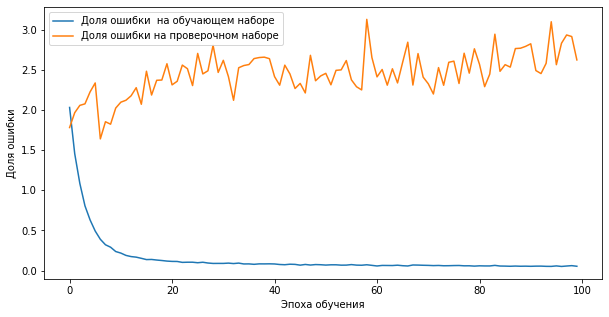

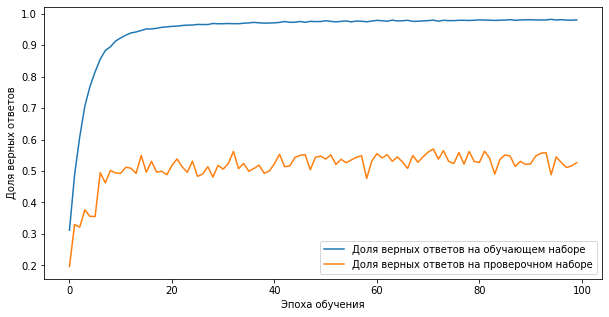

In [28]:
chart(history_model_LSTM)

### Средний процент и таблица

In [29]:
# Посмотрим на результат на тестовой выборке
val_model_LSTM, average_model_LSTM = recognizeMultiClass(model_LSTM, xTest6Classes, "model_LSTM")

Нейронная сеть:  model_LSTM

О. Генри  распознано  61 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  49 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  23 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Клиффорд Саймак  распознано  51 % сеть считает, что это  Клиффорд Саймак ,  распознано ВЕРНО!
Макс Фрай  распознано  70 % сеть считает, что это  Макс Фрай ,  распознано ВЕРНО!
Рэй Брэдберри  распознано  51 % сеть считает, что это  Рэй Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  52 %


In [30]:
# C помощью функции получаем значения на последней эпохе
result_LSTM = table(history_model_LSTM)    


In [161]:
# Заносим результат в таблицу
df.loc['LSTM'] = [round(min(result_LSTM[0]),4), round(max(result_LSTM[1]*100), 4), round(min(result_LSTM[2]),4), round(max(result_LSTM[3]*100),4), average_model_LSTM]

In [31]:
# Сохраним веса если потребуется дальнейшее дообучение. 
model_LSTM.save_weights(f'model_LSTM - val_loss: {round(result_LSTM[2][-1],2)} - val_accuracy: {average_model_LSTM}.h5')

In [162]:
df

,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
LSTM,0.0517,98.2141,1.6403,57.0055,52.0


## Определим блоки которые улучшают или ухудшают точность model.evaluate()

Параметр **verbose** установлен в **0**. Чтобы не посмотреть на вывод. 

Ход эксперимента такой: Приравнием к 1 токены с шагом 100, начиная со 2(так как 1:unknow), например: 2-102 = 0, но на следующей итерации этому блоку возвращаются его значения, то следующий блок в 100 токенов так же приравнивается к 1. И так далее до конца массива.
   Если точность выросла, значит этот блок ухудшает точность и его номер будет заносится в список. Если точност падает, значит этот блок нужен и в будущем на их основе будем обучать сеть.


In [34]:

blocs_LSTM_losers = []   # Задаем пустой список, где будут хранится номера блоков, которые ухудшали точность

count_LSTM_losers = 0   # Счетчик кол-ва отключенных блоков


In [35]:
for i in range(maxWordsCount // 100):                           # Создаем цикл из 500 итераций (потому что максимальное кол-во слов в словаре частотности 50000 и отключаем по 100)
 
  print("Итерация: ", i)                                        # Печатаем номер итерации

  testWordIndexes_LSTM_losers = tokenizer.texts_to_sequences(testText)      # Создаем тестовый набор каждую итерацию

  for j in range(len(testWordIndexes_LSTM_losers)):             # Здесь будет цикл в цикле, в начале проходимся по классам   
    for k in range(len(testWordIndexes_LSTM_losers[j])):        # А здесь уже по элементам внутри класса
      if (testWordIndexes_LSTM_losers[j][k] > i * xLen + 1 and testWordIndexes_LSTM_losers[j][k] < i * xLen + 101):    # Если элементы попадают в текущий блок
        testWordIndexes_LSTM_losers[j][k] = 1                   # То они становятся 1

  xTest_losers, yTest_losers = createSetsMultiClasses(testWordIndexes_LSTM_losers, xLen, step)    # Создаем новую выборку

  hist_LSTM_losers = model_LSTM.evaluate(xTest_losers, yTest_losers, verbose=0)   # C помощью evaluate смтрим результат


  print(f"C удаленным блоком {i*xLen+2}:{i*xLen+102} точность: {hist_LSTM_losers[1]}, ошибка {hist_LSTM_losers[0]}")   # Выводим результат

  if hist_LSTM_losers[1] > result_LSTM[3][-1]:               # Если точность выростла, значит этот блок ушудшает точность и его потом следует исключить
    blocs_LSTM_losers.append(i)                              # Добавляем номера тех блоков, которые ухудшают точность
    print("в blocs_LSTM_losers добавлен блок №: ", i)
    count_LSTM_losers += 1                                   # Увеличиваем счетчик плохих блоков на 1
  print("\n")
     

Итерация:  0
C удаленным блоком 2:102 точность: 0.5062576532363892, ошибка 3.153907537460327


Итерация:  1
C удаленным блоком 102:202 точность: 0.5114468932151794, ошибка 2.662517547607422


Итерация:  2
C удаленным блоком 202:302 точность: 0.5210622549057007, ошибка 2.6282193660736084


Итерация:  3
C удаленным блоком 302:402 точность: 0.5193833708763123, ошибка 2.6179120540618896


Итерация:  4
C удаленным блоком 402:502 точность: 0.5254883766174316, ошибка 2.585020065307617


Итерация:  5
C удаленным блоком 502:602 точность: 0.5235042572021484, ошибка 2.622537136077881


Итерация:  6
C удаленным блоком 602:702 точность: 0.5164835453033447, ошибка 2.658144950866699


Итерация:  7
C удаленным блоком 702:802 точность: 0.526098906993866, ошибка 2.6096765995025635


Итерация:  8
C удаленным блоком 802:902 точность: 0.521672785282135, ошибка 2.630408763885498


Итерация:  9
C удаленным блоком 902:1002 точность: 0.5247252583503723, ошибка 2.592611789703369


Итерация:  10
C удаленным блок

In [37]:
# Посмотрим сколько всего блоков вошло в выборку, которые ушудшают точность предсказания
print(count_LSTM_losers)

204


In [38]:
# Можно посмотреть на номера этих блоков

for i in blocs_LSTM_losers:
  print (i, end=" ")

10 15 20 35 36 38 40 42 46 54 57 58 60 61 62 64 65 67 70 71 78 82 87 89 90 93 94 95 96 97 98 99 103 105 108 110 113 115 116 117 123 124 126 129 133 136 139 140 142 143 147 148 149 156 158 159 160 163 165 170 172 173 183 184 186 189 191 193 194 195 197 198 200 201 202 203 204 208 210 211 212 213 214 216 217 218 220 225 226 227 228 230 235 239 241 243 244 245 249 250 253 254 258 260 261 262 264 265 269 275 279 281 289 292 293 294 298 301 302 303 308 310 312 313 315 316 321 324 326 328 330 331 333 334 336 337 338 339 340 341 343 347 352 353 355 359 360 361 363 367 369 376 379 380 384 385 391 396 398 401 402 404 405 409 411 415 416 417 419 425 426 427 428 429 430 431 432 436 438 440 443 444 445 446 452 456 457 458 464 465 466 468 469 471 475 482 484 485 486 488 492 495 498 499 

 Из обучающего набора убираем блоки, которые ушудшали точность.

 В новые переменные super добавляем преобразованный текст индексов согласно словарю. Далее будем работать с ними.


In [39]:
trainWordIndexes_LSTM_disableLosers = tokenizer.texts_to_sequences(trainText)   # Создаем обучающий набор

for i in blocs_LSTM_losers:                                             # Проходим циклом по списку, в котором содержутся номера блоков которые следует обнулить. Они предоставлены выше

  for j in range(len(trainWordIndexes_LSTM_disableLosers)):             # Так же двумя циклами проходимся по текстам

    for k in range(len(trainWordIndexes_LSTM_disableLosers[j])):

      if (trainWordIndexes_LSTM_disableLosers[j][k] > i * xLen + 1 and trainWordIndexes_LSTM_disableLosers[j][k] < i * xLen + 102):
        trainWordIndexes_LSTM_disableLosers[j][k] = 1                   # Обнуляем эти блоки
 

In [40]:
testWordIndexes_LSTM_disableLosers = tokenizer.texts_to_sequences(testText)    # Создаем новый тестовый набор

In [50]:
# Исходя из отключеннх блоков создадим новые обучающие и тестовые выборки

xTrain_LSTM_disableLosers, yTrain_LSTM_disableLosers = createSetsMultiClasses(trainWordIndexes_LSTM_disableLosers, xLen, step)
xTest_LSTM_disableLosers, yTest_LSTM_disableLosers = createSetsMultiClasses(testWordIndexes_LSTM_disableLosers, xLen, step) 

### **Обучение только с хорошими блоками**

Используем ту же самую архитектуру и гиперпараметры как и обучали ранее. Чтобы более точно сравнить результаты. 

In [53]:
model_LSTM_disableLosers = Sequential()

model_LSTM_disableLosers.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM_disableLosers.add(SpatialDropout1D(0.4))

model_LSTM_disableLosers.add(BatchNormalization()) 

model_LSTM_disableLosers.add(LSTM(4, return_sequences=True)) 
model_LSTM_disableLosers.add(Dropout(0.5)) 
model_LSTM_disableLosers.add(BatchNormalization()) 

model_LSTM_disableLosers.add(Dense(100, activation="relu")) 
model_LSTM_disableLosers.add(Dropout(0.5)) 
model_LSTM_disableLosers.add(BatchNormalization()) 

model_LSTM_disableLosers.add(Flatten()) 
model_LSTM_disableLosers.add(Dense(6, activation='softmax'))

model_LSTM_disableLosers.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Обучим ту же самую сеть, но с уже отключенными блоками
history_model_LSTM_disableLosers = model_LSTM_disableLosers.fit(xTrain_LSTM_disableLosers, yTrain_LSTM_disableLosers, epochs=100, batch_size=200, validation_data=(xTest_LSTM_disableLosers, yTest_LSTM_disableLosers))

Epoch 1/100
89/89 [==============================] - 4s 20ms/step - loss: 2.1226 - accuracy: 0.2833 - val_loss: 1.8144 - val_accuracy: 0.3002
Epoch 2/100
89/89 [==============================] - 1s 15ms/step - loss: 1.6396 - accuracy: 0.4286 - val_loss: 2.3382 - val_accuracy: 0.0829
Epoch 3/100
89/89 [==============================] - 1s 15ms/step - loss: 1.2966 - accuracy: 0.5317 - val_loss: 2.4759 - val_accuracy: 0.2866
Epoch 4/100
89/89 [==============================] - 1s 15ms/step - loss: 1.0404 - accuracy: 0.6184 - val_loss: 2.5117 - val_accuracy: 0.2366
Epoch 5/100
89/89 [==============================] - 1s 15ms/step - loss: 0.8345 - accuracy: 0.6902 - val_loss: 2.1848 - val_accuracy: 0.3405
Epoch 6/100
89/89 [==============================] - 1s 15ms/step - loss: 0.6728 - accuracy: 0.7482 - val_loss: 1.9318 - val_accuracy: 0.3777
Epoch 7/100
89/89 [==============================] - 1s 15ms/step - loss: 0.5592 - accuracy: 0.7928 - val_loss: 1.7117 - val_accuracy: 0.4026
Epoch 

### График 








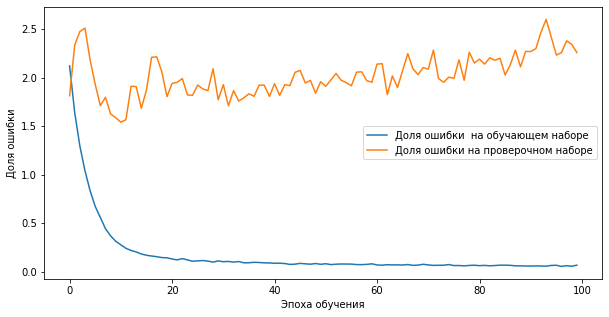

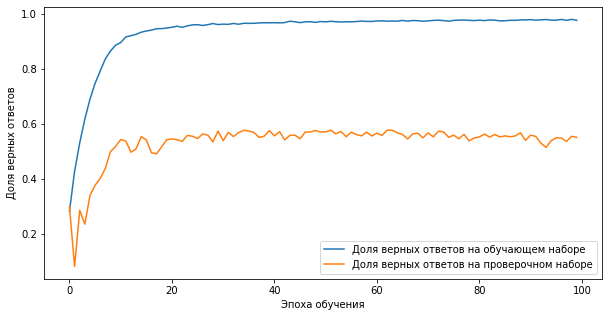

In [55]:
chart(history_model_LSTM_disableLosers)

### Средний процент и таблица

In [56]:
# Посмотрим на результат на тестовой выборке
val_model_LSTM_disableLosers, average_model_LSTM_disableLosers = recognizeMultiClass(model_LSTM_disableLosers, xTest6Classes, "model_LSTM_disableLosers")

Нейронная сеть:  model_LSTM_disableLosers

О. Генри  распознано  70 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  34 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  30 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Клиффорд Саймак  распознано  29 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Макс Фрай  распознано  74 % сеть считает, что это  Макс Фрай ,  распознано ВЕРНО!
Рэй Брэдберри  распознано  68 % сеть считает, что это  Рэй Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  55 %


In [78]:
# C помощью функции получаем значения на последней эпохе
result_model_LSTM_disableLosers = table(history_model_LSTM_disableLosers)    

In [163]:
# Заносим результат в таблицу
df.loc['LSTM с выключенными плохими блоками'] = [round(min(result_model_LSTM_disableLosers[0]),4), round(max(result_model_LSTM_disableLosers[1]*100), 4), round(min(result_model_LSTM_disableLosers[2]),4), round(max(result_model_LSTM_disableLosers[3]*100),4), average_model_LSTM_disableLosers]

In [58]:
# Сохраним веса если потребуется дальнейшее дообучение. 
model_LSTM_disableLosers.save_weights(f'model_LSTM_disableLosers - val_loss: {round(result_model_LSTM_disableLosers[2][-1],2)} - val_accuracy: {average_model_LSTM_disableLosers}.h5')

In [164]:
df

,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
LSTM,0.0517,98.2141,1.6403,57.0055,52.0
LSTM с выключенными плохими блоками,0.0539,98.0558,1.5420,57.8144,55.0


# Эксперимент 2

**Что же результат ясен, но что будет если сделать тоже самое на другой архитектуре сети со слоем Conv1D. Можно продолжить эксперимент и посмотреть.**

## Embedding + Conv1D сеть

In [81]:
model_Conv_1D = Sequential() 

model_Conv_1D.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv_1D.add(SpatialDropout1D(0.2)) 
model_Conv_1D.add(BatchNormalization())  
model_Conv_1D.add(Conv1D(20, 5, activation="relu", padding='same'))  
model_Conv_1D.add(Conv1D(20, 5, activation="relu")) 
model_Conv_1D.add(MaxPooling1D(2))
model_Conv_1D.add(Dropout(0.2)) 
model_Conv_1D.add(BatchNormalization()) 
model_Conv_1D.add(Flatten()) 
model_Conv_1D.add(Dense(6, activation='softmax')) 


model_Conv_1D.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Обучение

In [82]:
history_model_Conv_1D = model_Conv_1D.fit(xTrain, yTrain, epochs=100, batch_size=200, validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 29s 14ms/step - loss: 2.0130 - accuracy: 0.2525 - val_loss: 1.7483 - val_accuracy: 0.1761
Epoch 2/100
89/89 [==============================] - 1s 10ms/step - loss: 1.0962 - accuracy: 0.5838 - val_loss: 1.8509 - val_accuracy: 0.1774
Epoch 3/100
89/89 [==============================] - 1s 9ms/step - loss: 0.5191 - accuracy: 0.8136 - val_loss: 1.9100 - val_accuracy: 0.3384
Epoch 4/100
89/89 [==============================] - 1s 10ms/step - loss: 0.2450 - accuracy: 0.9168 - val_loss: 2.1081 - val_accuracy: 0.3463
Epoch 5/100
89/89 [==============================] - 1s 9ms/step - loss: 0.1182 - accuracy: 0.9612 - val_loss: 1.7330 - val_accuracy: 0.4127
Epoch 6/100
89/89 [==============================] - 1s 10ms/step - loss: 0.0663 - accuracy: 0.9790 - val_loss: 1.7145 - val_accuracy: 0.4484
Epoch 7/100
89/89 [==============================] - 1s 10ms/step - loss: 0.0466 - accuracy: 0.9839 - val_loss: 1.5544 - val_accuracy: 0.5298
Epoch 8

### График 








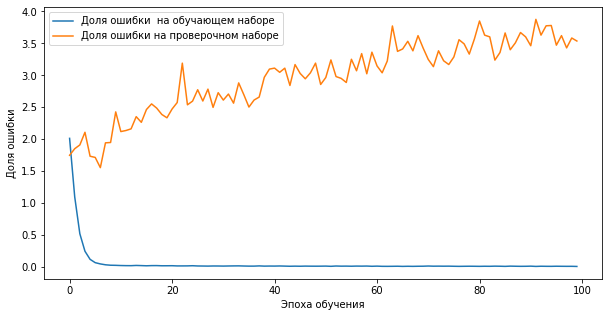

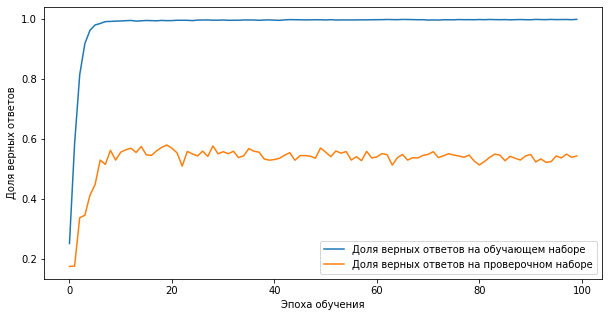

In [83]:
chart(history_model_Conv_1D)

### Средний процент и таблица

In [84]:
# Посмотрим на результат на тестовой выборке
val_model_Conv_1D, average_model_Conv_1D = recognizeMultiClass(model_Conv_1D, xTest6Classes, "model_Conv_1D")

Нейронная сеть:  model_Conv_1D

О. Генри  распознано  64 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  40 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  32 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Клиффорд Саймак  распознано  36 % сеть считает, что это  Клиффорд Саймак ,  распознано ВЕРНО!
Макс Фрай  распознано  76 % сеть считает, что это  Макс Фрай ,  распознано ВЕРНО!
Рэй Брэдберри  распознано  54 % сеть считает, что это  Рэй Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  54 %


In [85]:
# C помощью функции получаем значения на последней эпохе
result_model_Conv_1D = table(history_model_Conv_1D)    

In [165]:
# Заносим результат в таблицу
df.loc['Conv_1D'] = [round(min(result_model_Conv_1D[0]),4), round(max(result_model_Conv_1D[1]*100), 4), round(min(result_model_Conv_1D[2]),4), round(max(result_model_Conv_1D[3]*100),4), average_model_Conv_1D]

In [87]:
# Сохраним веса если потребуется дальнейшее дообучение. 
model_Conv_1D.save_weights(f'model_Conv_1D - val_loss: {round(result_model_Conv_1D[2][-1],2)} - val_accuracy: {average_model_Conv_1D}.h5')

In [166]:
df

,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
LSTM,0.0517,98.2141,1.6403,57.0055,52.0
LSTM с выключенными плохими блоками,0.0539,98.0558,1.5420,57.8144,55.0
Conv_1D,0.0070,99.7683,1.5544,57.9976,54.0


##  Аналогичным образом как и с LSTM, отключим блоки и проверим результат

In [89]:
blocs_conv1D_losers = []

count_conv1D_losers = 0   # Счетчик кол-ва отключенных блоков

In [90]:
for i in range(maxWordsCount // 100):                           # Создаем цикл из 500 итераций (потому что максимальное кол-во слов в словаре частотности 50000 и отключаем по 100)

  print("Итерация: ", i)

  testWordIndexes_conv1D_losers= tokenizer.texts_to_sequences(testText)      # Создаем тестовый набор каждую итерацию

  for j in range(len(testWordIndexes_conv1D_losers)):                        
    for k in range(len(testWordIndexes_conv1D_losers[j])):
      if (testWordIndexes_conv1D_losers[j][k] > i * xLen + 1 and testWordIndexes_conv1D_losers[j][k] < i * xLen + 101):
        testWordIndexes_conv1D_losers[j][k] = 1

  xTest_conv1D_losers, yTest_conv1D_losers = createSetsMultiClasses(testWordIndexes_conv1D_losers, xLen, step)    # Создаем новую выборку

  hist_Conv_1D_losers = model_Conv_1D.evaluate(xTest_conv1D_losers, yTest_conv1D_losers, verbose=0)  


  print(f"C удаленным блоком {i*xLen+2}:{i*xLen+102} точность: {hist_Conv_1D_losers[1]}, ошибка {hist_Conv_1D_losers[0]}")

  if hist_Conv_1D_losers[1] > result_model_Conv_1D[3][-1]:
    blocs_conv1D_losers.append(i)                              # Добавляем номера тех блоков, которые ухудшают точность
    print("в blocs_conv1D_losers  добавлен блок №: ", i)
    count_conv1D_losers += 1
  print("\n")
     

Итерация:  0
C удаленным блоком 2:102 точность: 0.42826616764068604, ошибка 5.648995399475098


Итерация:  1
C удаленным блоком 102:202 точность: 0.5296092629432678, ошибка 3.434819459915161


Итерация:  2
C удаленным блоком 202:302 точность: 0.5347985625267029, ошибка 3.546869993209839


Итерация:  3
C удаленным блоком 302:402 точность: 0.5349511504173279, ошибка 3.4864444732666016


Итерация:  4
C удаленным блоком 402:502 точность: 0.5361721515655518, ошибка 3.5645878314971924


Итерация:  5
C удаленным блоком 502:602 точность: 0.5378510355949402, ошибка 3.5764527320861816


Итерация:  6
C удаленным блоком 602:702 точность: 0.5357142686843872, ошибка 3.569016695022583


Итерация:  7
C удаленным блоком 702:802 точность: 0.5384615659713745, ошибка 3.5177738666534424


Итерация:  8
C удаленным блоком 802:902 точность: 0.5355616807937622, ошибка 3.5465567111968994


Итерация:  9
C удаленным блоком 902:1002 точность: 0.5441086888313293, ошибка 3.5276899337768555
в blocs_conv1D_losers  доб

In [91]:
# Посмотрим сколько всего блоков вошло в выборку, которые ушудшают точность предсказания
print(count_conv1D_losers)

163


In [92]:
# Можно посмотреть на номера этих блоков

for i in blocs_conv1D_losers:
  print (i, end=" ")

9 10 16 18 23 27 28 29 32 33 46 55 56 59 60 63 64 66 67 70 77 79 83 87 89 90 92 98 99 101 107 112 117 118 119 125 126 128 130 131 134 147 149 150 155 157 159 163 164 167 168 170 171 173 180 183 185 193 195 201 202 203 204 209 211 212 216 217 224 225 227 230 232 236 238 240 242 245 246 248 249 251 253 254 269 270 271 272 276 278 281 282 291 301 305 307 308 309 312 314 319 321 330 333 334 336 337 341 344 346 350 353 355 357 358 359 363 370 373 374 376 379 380 383 384 388 391 392 399 400 403 405 407 408 412 420 424 426 427 431 440 443 447 448 449 450 452 453 457 458 467 468 473 474 485 486 489 490 491 492 493 496 497 

 Из обучающего набора убираем блоки, которые ушудшали точность.

 В новые переменные super добавляем преобразованный текст индексов согласно словарю. Далее будем работать с ними.


In [93]:
trainWordIndexes_conv1D_disableLosers = tokenizer.texts_to_sequences(trainText)   # Создаем обучающий набор

for i in blocs_conv1D_losers:

  for j in range(len(trainWordIndexes_conv1D_disableLosers)):  

    for k in range(len(trainWordIndexes_conv1D_disableLosers[j])):

      if (trainWordIndexes_conv1D_disableLosers[j][k] > i * xLen + 1 and trainWordIndexes_conv1D_disableLosers[j][k] < i * xLen + 102):
        trainWordIndexes_conv1D_disableLosers[j][k] = 1
 

In [94]:
testWordIndexes_conv1D_disableLosers = tokenizer.texts_to_sequences(testText)

In [95]:
# Исходя из отключеннх блоков создадим новые тестовые выборки

xTrain_conv1D_disableLosers , yTrain_conv1D_disableLosers = createSetsMultiClasses(trainWordIndexes_conv1D_disableLosers, xLen, step)
xTest_conv1D_disableLosers, yTest_conv1D_disableLosers = createSetsMultiClasses(testWordIndexes_conv1D_disableLosers, xLen, step) 

### Обучение с хорошими блоками

In [96]:
model_Conv1D_disableLosers = Sequential() 

model_Conv1D_disableLosers.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv1D_disableLosers.add(SpatialDropout1D(0.2)) 
model_Conv1D_disableLosers.add(BatchNormalization())  
model_Conv1D_disableLosers.add(Conv1D(20, 5, activation="relu", padding='same'))  
model_Conv1D_disableLosers.add(Conv1D(20, 5, activation="relu")) 
model_Conv1D_disableLosers.add(MaxPooling1D(2))
model_Conv1D_disableLosers.add(Dropout(0.2)) 
model_Conv1D_disableLosers.add(BatchNormalization()) 
model_Conv1D_disableLosers.add(Flatten()) 
model_Conv1D_disableLosers.add(Dense(6, activation='softmax')) 


model_Conv1D_disableLosers.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [97]:
history_model_Conv1D_disableLosers = model_Conv1D_disableLosers.fit(xTrain_conv1D_disableLosers, yTrain_conv1D_disableLosers, epochs=100, batch_size=200, validation_data=(xTest_conv1D_disableLosers, yTest_conv1D_disableLosers))

Epoch 1/100
89/89 [==============================] - 2s 12ms/step - loss: 1.9412 - accuracy: 0.2887 - val_loss: 1.8809 - val_accuracy: 0.1882
Epoch 2/100
89/89 [==============================] - 1s 9ms/step - loss: 1.0909 - accuracy: 0.5868 - val_loss: 2.1388 - val_accuracy: 0.0958
Epoch 3/100
89/89 [==============================] - 1s 9ms/step - loss: 0.6239 - accuracy: 0.7659 - val_loss: 2.5298 - val_accuracy: 0.0818
Epoch 4/100
89/89 [==============================] - 1s 9ms/step - loss: 0.3500 - accuracy: 0.8769 - val_loss: 1.8551 - val_accuracy: 0.2518
Epoch 5/100
89/89 [==============================] - 1s 9ms/step - loss: 0.1927 - accuracy: 0.9362 - val_loss: 1.6837 - val_accuracy: 0.3509
Epoch 6/100
89/89 [==============================] - 1s 9ms/step - loss: 0.1157 - accuracy: 0.9618 - val_loss: 1.5759 - val_accuracy: 0.4931
Epoch 7/100
89/89 [==============================] - 1s 9ms/step - loss: 0.0793 - accuracy: 0.9742 - val_loss: 1.5334 - val_accuracy: 0.5185
Epoch 8/100


### График 








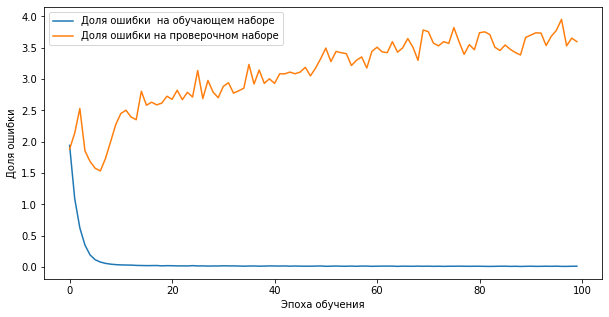

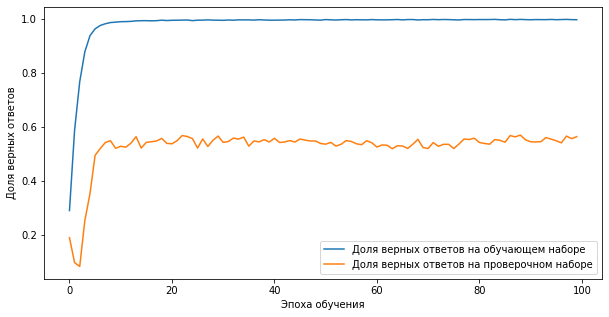

In [98]:
chart(history_model_Conv1D_disableLosers)

### Средний процент и таблица

In [99]:
# Посмотрим на результат на тестовой выборке
val_model_Conv1D_disableLosers, average_model_Conv1D_disableLosers = recognizeMultiClass(model_Conv1D_disableLosers, xTest6Classes, "model_Conv1D_disableLosers")

Нейронная сеть:  model_Conv1D_disableLosers

О. Генри  распознано  42 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  36 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  38 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Клиффорд Саймак  распознано  52 % сеть считает, что это  Клиффорд Саймак ,  распознано ВЕРНО!
Макс Фрай  распознано  76 % сеть считает, что это  Макс Фрай ,  распознано ВЕРНО!
Рэй Брэдберри  распознано  64 % сеть считает, что это  Рэй Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  56 %


In [167]:
result_model_Conv1D_disableLosers = table(history_model_Conv1D_disableLosers)    # C помощью функции получаем значения на последней эпохе

# Заносим результат в таблицу
df.loc['Conv_1D с выключенными плохими блоками'] = [round(min(result_model_Conv1D_disableLosers[0]),4), round(max(result_model_Conv1D_disableLosers[1]*100), 4), round(min(result_model_Conv1D_disableLosers[2]),4), round(max(result_model_Conv1D_disableLosers[3]*100),4), average_model_Conv1D_disableLosers]

In [101]:
# Сохраним веса если потребуется дальнейшее дообучение. 
model_Conv1D_disableLosers.save_weights(f'model_Conv1D_disableLosers - val_loss: {round(result_model_Conv1D_disableLosers[2][-1],2)} - val_accuracy: {average_model_Conv1D_disableLosers}.h5')

In [168]:
df

,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
LSTM,0.0517,98.2141,1.6403,57.0055,52.0
LSTM с выключенными плохими блоками,0.0539,98.0558,1.5420,57.8144,55.0
Conv_1D,0.0070,99.7683,1.5544,57.9976,54.0
Conv_1D с выключенными плохими блоками,0.0090,99.6948,1.5334,56.8223,56.0


# Обучение нейронной сети с плохими блоками

Это в задание не входит, но все же интересно какая будет точность если обучить сеть только с блоками, которые ухудшают точность.
  Для этого поменяем условие и будем добавлять в выборку, только те блоки, которые ухудшают точность.
  Архитектура сети и код будет идентичные.

## Сеть с LSTM

In [103]:
blocs_LSTM_best = []

count_LSTM_best = 0   # Счетчик кол-ва отключенных блоков

In [104]:
for i in range(maxWordsCount // 100):                           # Создаем цикл из 500 итераций (потому что максимальное кол-во слов в словаре частотности 50000 и отключаем по 100)
 
  print("Итерация: ", i)

  testWordIndexes_LSTM_best = tokenizer.texts_to_sequences(testText)      # Создаем тестовый набор каждую итерацию

  for j in range(len(testWordIndexes_LSTM_best)):                        
    for k in range(len(testWordIndexes_LSTM_best[j])):
      if (testWordIndexes_LSTM_best[j][k] > i * xLen + 1 and testWordIndexes_LSTM_best[j][k] < i * xLen + 101):
        testWordIndexes_LSTM_best[j][k] = 1

  xTest_LSTM_best, yTest_LSTM_best = createSetsMultiClasses(testWordIndexes_LSTM_best, xLen, step)    # Создаем новую выборку

  hist_LSTM_best = model_LSTM.evaluate(xTest_LSTM_best, yTest_LSTM_best, verbose=0)  


  print(f"C удаленным блоком {i*xLen+2}:{i*xLen+102} точность: {hist_LSTM_best[1]}, ошибка {hist_LSTM_best[0]}")

  if hist_LSTM_best[1] < result_LSTM[3][-1]:
    blocs_LSTM_best.append(i)                              # Добавляем номера тех блоков, которые ухудшают точность
    print("в blocs_LSTM_best добавлен блок №: ", i)
    count_LSTM_best += 1
  print("\n")
     

Итерация:  0
C удаленным блоком 2:102 точность: 0.5062576532363892, ошибка 3.153907537460327
в blocs_LSTM_best добавлен блок №:  0


Итерация:  1
C удаленным блоком 102:202 точность: 0.5114468932151794, ошибка 2.662517547607422
в blocs_LSTM_best добавлен блок №:  1


Итерация:  2
C удаленным блоком 202:302 точность: 0.5210622549057007, ошибка 2.6282193660736084
в blocs_LSTM_best добавлен блок №:  2


Итерация:  3
C удаленным блоком 302:402 точность: 0.5193833708763123, ошибка 2.6179120540618896
в blocs_LSTM_best добавлен блок №:  3


Итерация:  4
C удаленным блоком 402:502 точность: 0.5254883766174316, ошибка 2.585020065307617
в blocs_LSTM_best добавлен блок №:  4


Итерация:  5
C удаленным блоком 502:602 точность: 0.5235042572021484, ошибка 2.622537136077881
в blocs_LSTM_best добавлен блок №:  5


Итерация:  6
C удаленным блоком 602:702 точность: 0.5164835453033447, ошибка 2.658144950866699
в blocs_LSTM_best добавлен блок №:  6


Итерация:  7
C удаленным блоком 702:802 точность: 0.526

In [105]:
# Посмотрим сколько всего блоков вошло в выборку, которые ушудшают точность предсказания
print(count_LSTM_best)

205


In [107]:
# Можно посмотреть на номера этих блоков

for i in blocs_LSTM_best:
  print (i, end=" ")

0 1 2 3 4 5 6 7 8 9 11 12 13 14 16 17 18 19 21 22 23 24 25 26 27 28 29 30 31 32 33 34 37 39 41 43 44 45 47 48 49 50 51 53 55 56 59 63 66 69 72 73 74 75 76 77 79 81 83 85 86 88 92 100 102 104 106 109 111 112 114 118 119 120 121 122 125 127 128 130 131 132 135 137 138 141 145 146 150 151 152 153 154 157 161 164 166 167 169 174 175 176 177 178 179 180 181 182 185 187 188 190 192 196 199 205 206 209 215 221 223 231 232 234 236 237 238 246 247 248 252 255 256 257 263 266 267 268 270 271 272 273 278 280 282 283 284 285 286 287 291 299 304 305 306 311 318 319 322 323 325 327 332 342 345 348 349 356 364 365 366 371 372 373 375 378 381 383 387 393 394 395 400 406 407 408 413 420 421 434 435 447 450 454 460 461 463 476 477 480 487 490 491 493 496 

In [109]:
trainWordIndexes_LSTM_disableBest = tokenizer.texts_to_sequences(trainText)   # Создаем обучающий набор

for i in blocs_LSTM_best:

  for j in range(len(trainWordIndexes_LSTM_disableBest)):  

    for k in range(len(trainWordIndexes_LSTM_disableBest[j])):

      if (trainWordIndexes_LSTM_disableBest[j][k] > i * xLen + 1 and trainWordIndexes_LSTM_disableBest[j][k] < i * xLen + 102):
        trainWordIndexes_LSTM_disableBest[j][k] = 1
 

In [110]:
testWordIndexes_LSTM_disableBest = tokenizer.texts_to_sequences(testText)

In [111]:
# Исходя из отключеннх блоков создадим новые тестовые выборки

xTrain_LSTM_disableBest, yTrain_LSTM_disableBest = createSetsMultiClasses(trainWordIndexes_LSTM_disableBest, xLen, step)
xTest_LSTM_disableBest, yTest_LSTM_disableBest = createSetsMultiClasses(testWordIndexes_LSTM_disableBest, xLen, step) 

In [112]:
model_LSTM_disableBest = Sequential()

model_LSTM_disableBest.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM_disableBest.add(SpatialDropout1D(0.4))

model_LSTM_disableBest.add(BatchNormalization()) 

model_LSTM_disableBest.add(LSTM(4, return_sequences=True)) 
model_LSTM_disableBest.add(Dropout(0.5)) 
model_LSTM_disableBest.add(BatchNormalization()) 

model_LSTM_disableBest.add(Dense(100, activation="relu")) 
model_LSTM_disableBest.add(Dropout(0.5)) 
model_LSTM_disableBest.add(BatchNormalization()) 

model_LSTM_disableBest.add(Flatten()) 
model_LSTM_disableBest.add(Dense(6, activation='softmax'))

model_LSTM_disableBest.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [113]:
# Обучим ту же самую сеть, но с уже отключенными блоками
history_model_LSTM_disableBest = model_LSTM_disableBest.fit(xTrain_LSTM_disableBest, yTrain_LSTM_disableBest, epochs=100, batch_size=200, validation_data=(xTest_LSTM_disableBest, yTest_LSTM_disableBest))

Epoch 1/100
89/89 [==============================] - 4s 20ms/step - loss: 2.3962 - accuracy: 0.2101 - val_loss: 1.7703 - val_accuracy: 0.3002
Epoch 2/100
89/89 [==============================] - 1s 15ms/step - loss: 2.1903 - accuracy: 0.2282 - val_loss: 1.7504 - val_accuracy: 0.3002
Epoch 3/100
89/89 [==============================] - 1s 15ms/step - loss: 2.0909 - accuracy: 0.2323 - val_loss: 1.7281 - val_accuracy: 0.1738
Epoch 4/100
89/89 [==============================] - 1s 15ms/step - loss: 2.0244 - accuracy: 0.2414 - val_loss: 1.8369 - val_accuracy: 0.1658
Epoch 5/100
89/89 [==============================] - 1s 15ms/step - loss: 1.9633 - accuracy: 0.2531 - val_loss: 1.9838 - val_accuracy: 0.1738
Epoch 6/100
89/89 [==============================] - 1s 15ms/step - loss: 1.8493 - accuracy: 0.2992 - val_loss: 2.0739 - val_accuracy: 0.1731
Epoch 7/100
89/89 [==============================] - 1s 15ms/step - loss: 1.6849 - accuracy: 0.3576 - val_loss: 2.5678 - val_accuracy: 0.1770
Epoch 

### График 








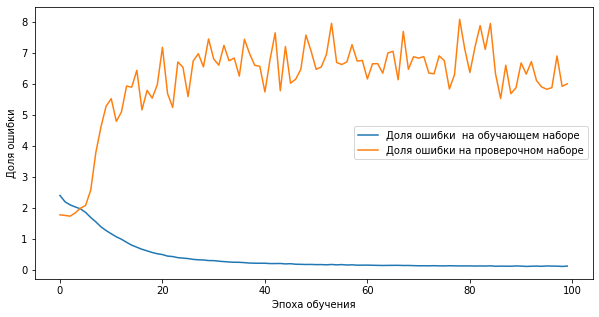

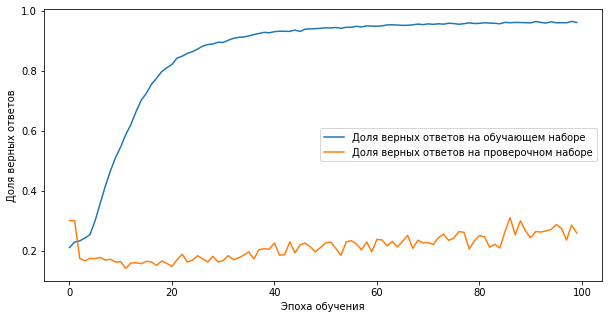

In [131]:
chart(history_model_LSTM_disableBest)

In [114]:
# Посмотрим на результат на тестовой выборке
val_model_LSTM_disableBest, average_model_LSTM_disableBest = recognizeMultiClass(model_LSTM_disableBest, xTest6Classes, "model_LSTM_disableBest")

Нейронная сеть:  model_LSTM_disableBest

О. Генри  распознано  62 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  14 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Булгаков  распознано  27 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Клиффорд Саймак  распознано  11 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Макс Фрай  распознано  25 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Рэй Брэдберри  распознано  25 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!

Средний процент распознавания  25 %


In [169]:
result_model_LSTM_disableBest = table(history_model_LSTM_disableBest)    # C помощью функции получаем значения на последней эпохе

# Заносим результат в таблицу
df.loc['LSTM с выключенными хорошими блоками'] = [round(min(result_model_LSTM_disableBest[0]),4), round(max(result_model_LSTM_disableBest[1]*100), 4), round(min(result_model_LSTM_disableBest[2]),4), round(max(result_model_LSTM_disableBest[3]*100),4), average_model_LSTM_disableBest]

In [170]:
df

,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
LSTM,0.0517,98.2141,1.6403,57.0055,52.0
LSTM с выключенными плохими блоками,0.0539,98.0558,1.5420,57.8144,55.0
Conv_1D,0.0070,99.7683,1.5544,57.9976,54.0
Conv_1D с выключенными плохими блоками,0.0090,99.6948,1.5334,56.8223,56.0
LSTM с выключенными хорошими блоками,0.1034,96.4734,1.7281,30.9829,25.0


## Cеть Conv1D с плохими блоками

In [120]:
blocs_Conv1D_best = []

count_Conv1D_best = 0   # Счетчик кол-ва отключенных блоков

In [121]:
for i in range(maxWordsCount // 100):                           # Создаем цикл из 500 итераций (потому что максимальное кол-во слов в словаре частотности 50000 и отключаем по 100)

  print("Итерация: ", i)

  testWordIndexes_conv1D_best= tokenizer.texts_to_sequences(testText)      # Создаем тестовый набор каждую итерацию

  for j in range(len(testWordIndexes_conv1D_best)):                        
    for k in range(len(testWordIndexes_conv1D_best[j])):
      if (testWordIndexes_conv1D_best[j][k] > i * xLen + 1 and testWordIndexes_conv1D_best[j][k] < i * xLen + 101):
        testWordIndexes_conv1D_best[j][k] = 1

  xTest_conv1D_best, yTest_conv1D_best = createSetsMultiClasses(testWordIndexes_conv1D_best, xLen, step)    # Создаем новую выборку

  hist_Conv_1D_best = model_Conv_1D.evaluate(xTest_conv1D_best, yTest_conv1D_best, verbose=0)  


  print(f"C удаленным блоком {i*xLen+2}:{i*xLen+102} точность: {hist_Conv_1D_best[1]}, ошибка {hist_Conv_1D_best[0]}")

  if hist_Conv_1D_best[1] < result_model_Conv_1D[3][-1]:
    blocs_Conv1D_best.append(i)                              # Добавляем номера тех блоков, которые ухудшают точность
    print("в blocs_Conv1D_best  добавлен блок №: ", i)
    count_Conv1D_best += 1
  print("\n")
     

Итерация:  0
C удаленным блоком 2:102 точность: 0.42826616764068604, ошибка 5.648995399475098
в blocs_Conv1D_best  добавлен блок №:  0


Итерация:  1
C удаленным блоком 102:202 точность: 0.5296092629432678, ошибка 3.434819459915161
в blocs_Conv1D_best  добавлен блок №:  1


Итерация:  2
C удаленным блоком 202:302 точность: 0.5347985625267029, ошибка 3.546869993209839
в blocs_Conv1D_best  добавлен блок №:  2


Итерация:  3
C удаленным блоком 302:402 точность: 0.5349511504173279, ошибка 3.4864444732666016
в blocs_Conv1D_best  добавлен блок №:  3


Итерация:  4
C удаленным блоком 402:502 точность: 0.5361721515655518, ошибка 3.5645878314971924
в blocs_Conv1D_best  добавлен блок №:  4


Итерация:  5
C удаленным блоком 502:602 точность: 0.5378510355949402, ошибка 3.5764527320861816
в blocs_Conv1D_best  добавлен блок №:  5


Итерация:  6
C удаленным блоком 602:702 точность: 0.5357142686843872, ошибка 3.569016695022583
в blocs_Conv1D_best  добавлен блок №:  6


Итерация:  7
C удаленным блоком 

In [122]:
# Посмотрим сколько всего блоков вошло в выборку, которые ушудшают точность предсказания
print(count_Conv1D_best)

238


In [123]:
# Можно посмотреть на номера этих блоков

for i in blocs_Conv1D_best:
  print (i, end=" ")

0 1 2 3 4 5 6 7 8 11 12 13 14 15 17 19 20 21 22 24 25 26 34 35 36 37 38 39 40 41 42 43 45 47 48 49 50 51 52 53 54 57 58 61 62 65 68 69 71 72 73 74 75 76 78 80 81 82 84 85 86 88 91 93 95 96 97 100 102 103 104 105 106 108 109 110 111 113 114 115 116 120 121 122 123 127 129 132 133 135 136 137 139 140 141 142 144 146 151 152 153 156 158 162 165 166 169 172 174 176 177 179 181 184 186 187 188 189 190 192 194 197 199 200 205 206 210 214 215 218 219 220 221 226 228 229 231 233 235 237 239 243 244 247 255 256 259 261 263 264 265 266 267 273 274 275 280 284 286 287 288 289 292 293 296 297 299 302 303 304 306 311 315 317 318 322 324 325 327 332 335 338 342 343 345 351 352 356 360 361 365 366 368 369 371 372 378 381 385 386 387 394 395 396 398 402 404 406 409 411 413 415 416 423 428 429 430 433 434 439 441 442 445 446 451 455 460 463 465 469 471 472 475 480 483 487 488 499 

In [125]:
trainWordIndexes_Conv1D_disableBest = tokenizer.texts_to_sequences(trainText)   # Создаем обучающий набор

for i in blocs_Conv1D_best:

  for j in range(len(trainWordIndexes_Conv1D_disableBest)):  

    for k in range(len(trainWordIndexes_Conv1D_disableBest[j])):

      if (trainWordIndexes_Conv1D_disableBest[j][k] > i * xLen + 1 and trainWordIndexes_Conv1D_disableBest[j][k] < i * xLen + 102):
        trainWordIndexes_Conv1D_disableBest[j][k] = 1
 

In [126]:
testWordIndexes_Conv1D_disableBest = tokenizer.texts_to_sequences(testText)

In [127]:
# Исходя из отключеннх блоков создадим новые тестовые выборки

xTrain_Conv1D_disableBest, yTrain_Conv1D_disableBest = createSetsMultiClasses(trainWordIndexes_Conv1D_disableBest, xLen, step)
xTest_Conv1D_disableBest, yTest_Conv1D_disableBest = createSetsMultiClasses(testWordIndexes_Conv1D_disableBest, xLen, step) 

In [128]:
model_Conv1D_disableBest = Sequential() 

model_Conv1D_disableBest.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv1D_disableBest.add(SpatialDropout1D(0.2)) 
model_Conv1D_disableBest.add(BatchNormalization())  
model_Conv1D_disableBest.add(Conv1D(20, 5, activation="relu", padding='same'))  
model_Conv1D_disableBest.add(Conv1D(20, 5, activation="relu")) 
model_Conv1D_disableBest.add(MaxPooling1D(2))
model_Conv1D_disableBest.add(Dropout(0.2)) 
model_Conv1D_disableBest.add(BatchNormalization()) 
model_Conv1D_disableBest.add(Flatten()) 
model_Conv1D_disableBest.add(Dense(6, activation='softmax')) 


model_Conv1D_disableBest.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [129]:
history_model_Conv1D_disableBest = model_Conv1D_disableBest.fit(xTrain_Conv1D_disableBest, yTrain_Conv1D_disableBest, epochs=100, batch_size=200, validation_data=(xTest_Conv1D_disableBest, yTest_Conv1D_disableBest))

Epoch 1/100
89/89 [==============================] - 2s 11ms/step - loss: 1.9981 - accuracy: 0.2456 - val_loss: 1.8736 - val_accuracy: 0.3002
Epoch 2/100
89/89 [==============================] - 1s 9ms/step - loss: 1.6203 - accuracy: 0.3795 - val_loss: 2.5038 - val_accuracy: 0.3002
Epoch 3/100
89/89 [==============================] - 1s 9ms/step - loss: 1.3474 - accuracy: 0.4843 - val_loss: 3.0045 - val_accuracy: 0.3002
Epoch 4/100
89/89 [==============================] - 1s 9ms/step - loss: 1.1173 - accuracy: 0.5817 - val_loss: 2.8343 - val_accuracy: 0.3002
Epoch 5/100
89/89 [==============================] - 1s 9ms/step - loss: 0.9050 - accuracy: 0.6679 - val_loss: 2.3953 - val_accuracy: 0.2869
Epoch 6/100
89/89 [==============================] - 1s 9ms/step - loss: 0.7335 - accuracy: 0.7382 - val_loss: 2.3703 - val_accuracy: 0.1734
Epoch 7/100
89/89 [==============================] - 1s 9ms/step - loss: 0.5927 - accuracy: 0.7929 - val_loss: 4.6099 - val_accuracy: 0.1842
Epoch 8/100


### График 








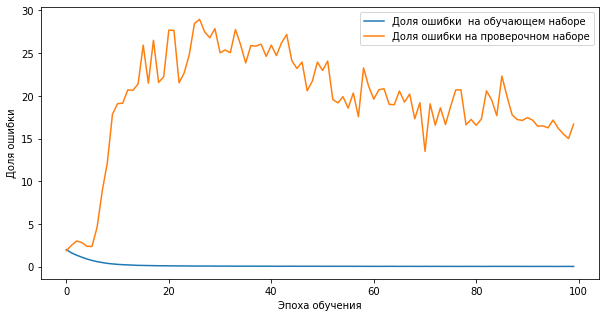

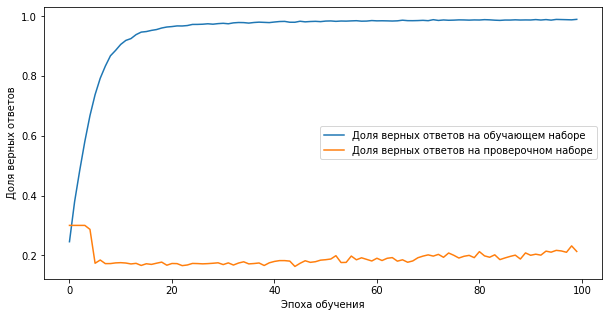

In [132]:
chart(history_model_Conv1D_disableBest)

In [133]:
# Посмотрим на результат на тестовой выборке
val_model_Conv1D_disableBest, average_model_Conv1D_disableBest = recognizeMultiClass(model_Conv1D_disableBest, xTest6Classes, "model_Conv1D_disableBest")

Нейронная сеть:  model_Conv1D_disableBest

О. Генри  распознано  44 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  7 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Булгаков  распознано  78 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Клиффорд Саймак  распознано  1 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Макс Фрай  распознано  8 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Рэй Брэдберри  распознано  1 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!

Средний процент распознавания  21 %


In [146]:
result_model_Conv1D_disableBest = table(history_model_Conv1D_disableBest)    # C помощью функции получаем значения на последней эпохе

In [171]:
# Заносим результат в таблицу
df.loc['Conv_1D с выключенными хорошими блоками'] = [round(min(result_model_Conv1D_disableBest[0]),4), round(max(result_model_Conv1D_disableBest[1]*100), 4), round(min(result_model_Conv1D_disableBest[2]),4), round(max(result_model_Conv1D_disableBest[3]*100),4), average_model_Conv1D_disableBest]

# Общая таблица

In [172]:
df

,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
LSTM,0.0517,98.2141,1.6403,57.0055,52.0
LSTM с выключенными плохими блоками,0.0539,98.0558,1.5420,57.8144,55.0
Conv_1D,0.0070,99.7683,1.5544,57.9976,54.0
Conv_1D с выключенными плохими блоками,0.0090,99.6948,1.5334,56.8223,56.0
LSTM с выключенными хорошими блоками,0.1034,96.4734,1.7281,30.9829,25.0
Conv_1D с выключенными хорошими блоками,0.0293,99.0392,1.8736,30.0214,21.0


# Выводы:

1. Цель домашнего задания: Опытным путем посмотреть как отключеие блоков токенов влияют на результат работы нейронной сети. Было выполнено. Результат приведен в таблице. 
2. По результатам опытов выявлено следующие:
 - Первая тысяча токенов (самые часто встречающие слова) очень сильно влияют на результат работы сети. Без них процент правильных ответов идет вниз.
- Чем больший индекс у слова в токенизаторе (чем реже оно встречается в тексте) тем меньше данный блок влияет на результат предсказания. (Это можно увидеть в строчке кода, где выводятся номера отключенных блоков. Для определения диапазона блока, его номер нужно умножить на 100.  
 - Безусловно данные показания приведенные в таблицы можно считать условными, так как веса устанавливаются случайно в начале обучения. И нужно брать средний результат из 10 опытов.

3. В данных примерах видно, что архитектура нейронной сети, а так же различные гиперпараметры не влияют на результат при отключение одного и того же блока токенов. То есть на разных архитектурах прослеживалась закнономерность:
  - Если в результате работы функции evaluate() результат стал хуже, значит этот блок нужен для большей точности какая бы сеть ни была ( LSTM или Conv1D)

4. При обучении нейронной сети на блоках, которые давали прирост точности, средний показатель вырос. 

5. Но если смотреть по авторам, то результат отличается. В одной сети LSTM по каждому автору свои показатели, в Conv1D другие. Но в любом случаи результат стал лучше.

6. Ради интереса обучил данные нейронные сети с той же самой архитектурой и гиперпараметры только на блоках, который давали худших результат при проверки на evaluate(). 
   - Результат стал значительно хуже.

7. Но не смотря на это нельзя с полной уверенность сказать что данный блок ухудшает работу сети. Так как на одних авторах он может давать прирост, а на других наоборот уменьшение точности. И можно судить только в целом на среднем проценте. 

8. При обучение сети удобно пользоваться графика, чтобы сразу было наглядно виден характер обучения нейронной сети. 

9. При сравнении результатов разных моделей и гипотиз также удобно использовать таблицу pandas.